# Pipeline vs MILP Evaluation Analysis

This notebook analyzes the results of the full GNN+EBM+Decoder+LP pipeline on eval scenarios and compares them with MILP solutions.

**Contents:**
1. Solve time breakdown (per SolveStage vs MILP)
2. Optimal cost breakdown (per SolveStage vs MILP)
3. Dispatch comparison visualization (pipeline LP vs MILP)
4. Cost components breakdown
5. Focus on hard_fix, repair_20, repair_100 solutions

In [2]:
import sys
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from dataclasses import dataclass, field
from enum import Enum
from typing import Dict, List, Tuple, Optional, Any

# Setup paths
BENCHMARK_ROOT = Path(r'C:\Users\Dell\projects\multilayer_milp_gnn\benchmark')
sys.path.insert(0, str(BENCHMARK_ROOT))

# Paths to data
PIPELINE_RESULTS_PATH = BENCHMARK_ROOT / 'outputs' / 'pipeline_eval_hard' / 'pipeline_eval_hard_results.pkl'
MILP_REPORTS_DIR = BENCHMARK_ROOT / 'outputs' / 'scenarios_eval_hard' / 'reports'

print(f"Pipeline results: {PIPELINE_RESULTS_PATH}")
print(f"MILP reports dir: {MILP_REPORTS_DIR}")
print(f"Pipeline exists: {PIPELINE_RESULTS_PATH.exists()}")
print(f"MILP dir exists: {MILP_REPORTS_DIR.exists()}")

Pipeline results: C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\pipeline_eval_hard\pipeline_eval_hard_results.pkl
MILP reports dir: C:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\scenarios_eval_hard\reports
Pipeline exists: True
MILP dir exists: True


## 1. Define Data Structures for Loading

In [3]:
class SolveStage(Enum):
    """Enum for tracking which stage produced the solution."""
    HARD_FIX = "hard_fix"
    REPAIR_20 = "repair_20"
    REPAIR_100 = "repair_100"
    FULL_SOFT = "full_soft"
    FAILED = "failed"


@dataclass
class TwoStageResult:
    """Result from two-stage LP optimization."""
    scenario_id: str
    status: str
    stage_used: SolveStage
    objective_value: float
    solve_time: float
    continuous_vars: Dict[str, np.ndarray]
    
    slack_used: float = 0.0
    decoder_deviation: float = 0.0
    n_flips: int = 0
    n_unfixed: int = 0
    n_unfixed_binaries_stage1: int = 0
    
    deviation_penalty_value: float = 0.0
    
    time_hard_fix: float = 0.0
    time_repair_20: float = 0.0
    time_repair_100: float = 0.0
    time_full_soft: float = 0.0
    
    slack_hard_fix: float = 0.0
    slack_repair_20: float = 0.0
    slack_repair_100: float = 0.0
    slack_full_soft: float = 0.0
    
    critical_indices: List[Tuple[str, int]] = field(default_factory=list)
    message: str = ""

# ScenarioPhysics & FeasiblePlan Dataclasses
from dataclasses import dataclass
from typing import Optional, List, Dict
import torch

@dataclass
class ScenarioPhysics:
    """Physics and constraints for a scenario."""
    n_zones: int
    n_timesteps: int
    n_regions: int = 1
    dt_hours: float = 1.0
    zone_names: Optional[List[str]] = None
    zone_to_region: Optional[Dict[str, int]] = None
    # Time series [Z, T]
    demand: Optional[torch.Tensor] = None
    solar_available: Optional[torch.Tensor] = None
    wind_available: Optional[torch.Tensor] = None
    hydro_ror: Optional[torch.Tensor] = None
    # Storage [Z]
    battery_power_mw: Optional[torch.Tensor] = None
    battery_capacity_mwh: Optional[torch.Tensor] = None
    battery_initial_soc: Optional[torch.Tensor] = None
    battery_efficiency: float = 0.90
    pumped_power_mw: Optional[torch.Tensor] = None
    pumped_capacity_mwh: Optional[torch.Tensor] = None
    pumped_initial_soc: Optional[torch.Tensor] = None
    pumped_efficiency: float = 0.80
    # Thermal & Nuclear [Z]
    thermal_capacity_mw: Optional[torch.Tensor] = None
    thermal_min_mw: Optional[torch.Tensor] = None
    nuclear_capacity_mw: Optional[torch.Tensor] = None
    # Hydro reservoir [Z]
    hydro_capacity_mw: Optional[torch.Tensor] = None
    hydro_capacity_mwh: Optional[torch.Tensor] = None
    hydro_initial: Optional[torch.Tensor] = None
    hydro_inflow: Optional[torch.Tensor] = None
    # DR [Z]
    dr_capacity_mw: Optional[torch.Tensor] = None
    dr_max_duration_hours: float = 4.0
    import_capacity_mw: float = 0.0

@dataclass
class FeasiblePlan:
    """Feasible dispatch plan from decoder."""
    thermal_on: torch.Tensor
    nuclear_on: torch.Tensor
    battery_charging: torch.Tensor
    battery_discharging: torch.Tensor
    pumped_charging: torch.Tensor
    pumped_discharging: torch.Tensor
    dr_active: torch.Tensor
    thermal_dispatch: torch.Tensor
    nuclear_dispatch: torch.Tensor
    battery_charge: torch.Tensor
    battery_discharge: torch.Tensor
    pumped_charge: torch.Tensor
    pumped_discharge: torch.Tensor
    demand_response: torch.Tensor
    solar_dispatch: torch.Tensor
    wind_dispatch: torch.Tensor
    hydro_dispatch: torch.Tensor
    unserved_energy: torch.Tensor
    curtailment: torch.Tensor
    net_import: torch.Tensor
    battery_soc: torch.Tensor
    pumped_level: torch.Tensor

    def to_tensor(self) -> torch.Tensor:
        """Convert to binary tensor [Z, T, F]."""
        Z, T = self.thermal_dispatch.shape
        u = torch.zeros(Z, T, 7)
        u[:, :, 0] = self.battery_charging
        u[:, :, 1] = self.battery_discharging
        u[:, :, 2] = self.pumped_charging
        u[:, :, 3] = self.pumped_discharging
        u[:, :, 4] = self.dr_active
        u[:, :, 5] = self.nuclear_on
        u[:, :, 6] = self.thermal_on
        return u

print("✓ ScenarioPhysics & FeasiblePlan defined")

print("Data structures defined.")

✓ ScenarioPhysics & FeasiblePlan defined
Data structures defined.


## 2. Load Pipeline Results

In [4]:
# Load pipeline results
with open(PIPELINE_RESULTS_PATH, 'rb') as f:
    pipeline_results = pickle.load(f)

print(f"Loaded {len(pipeline_results)} pipeline results")
print(f"Type: {type(pipeline_results)}")

# Inspect structure
if isinstance(pipeline_results, list) and len(pipeline_results) > 0:
    first = pipeline_results[0]
    print(f"First element type: {type(first)}")
    if isinstance(first, dict):
        print(f"Keys: {list(first.keys())}")
        print(f"scenario_id: {first.get('scenario_id')}")
        print(f"n_zones: {first.get('n_zones')}")
        print(f"lp_results count: {len(first.get('lp_results', []))}")
        print(f"best_sample_idx: {first.get('best_sample_idx')}")

Loaded 20 pipeline results
Type: <class 'list'>
First element type: <class 'dict'>
Keys: ['scenario_id', 'n_zones', 'samples', 'decoded_plans', 'lp_results', 'best_obj', 'best_sample_idx']
scenario_id: scenario_00001
n_zones: 177
lp_results count: 5
best_sample_idx: 0


In [5]:
# Build dataframe from pipeline results
# Structure: list of dicts with scenario_id, lp_results (list of TwoStageResult), etc.

pipeline_data = []
for item in pipeline_results:
    sc_id = item['scenario_id']
    lp_results = item.get('lp_results', [])
    best_idx = item.get('best_sample_idx', 0)
    
    # Use the best LP result for this scenario
    if lp_results and best_idx >= 0 and best_idx < len(lp_results):
        lp_res = lp_results[best_idx]
        
        # Handle TwoStageResult object
        if hasattr(lp_res, 'scenario_id'):
            row = {
                'scenario_id': sc_id,
                'status': lp_res.status,
                'stage_used': lp_res.stage_used.value if hasattr(lp_res.stage_used, 'value') else str(lp_res.stage_used),
                'objective_value': lp_res.objective_value,
                'solve_time': lp_res.solve_time,
                'slack_used': getattr(lp_res, 'slack_used', 0.0),
                'n_flips': getattr(lp_res, 'n_flips', 0),
                'time_hard_fix': getattr(lp_res, 'time_hard_fix', 0.0),
                'time_repair_20': getattr(lp_res, 'time_repair_20', 0.0),
                'time_repair_100': getattr(lp_res, 'time_repair_100', 0.0),
                'time_full_soft': getattr(lp_res, 'time_full_soft', 0.0),
                'slack_hard_fix': getattr(lp_res, 'slack_hard_fix', 0.0),
                'slack_repair_20': getattr(lp_res, 'slack_repair_20', 0.0),
                'slack_repair_100': getattr(lp_res, 'slack_repair_100', 0.0),
                'slack_full_soft': getattr(lp_res, 'slack_full_soft', 0.0),
                'continuous_vars': getattr(lp_res, 'continuous_vars', {}),
            }
        else:
            # lp_res might be a dict
            row = {
                'scenario_id': sc_id,
                'status': lp_res.get('status', 'unknown'),
                'stage_used': lp_res.get('stage_used', 'unknown'),
                'objective_value': lp_res.get('objective_value', np.nan),
                'solve_time': lp_res.get('solve_time', 0.0),
                'slack_used': lp_res.get('slack_used', 0.0),
                'n_flips': lp_res.get('n_flips', 0),
                'time_hard_fix': lp_res.get('time_hard_fix', 0.0),
                'time_repair_20': lp_res.get('time_repair_20', 0.0),
                'time_repair_100': lp_res.get('time_repair_100', 0.0),
                'time_full_soft': lp_res.get('time_full_soft', 0.0),
                'slack_hard_fix': lp_res.get('slack_hard_fix', 0.0),
                'slack_repair_20': lp_res.get('slack_repair_20', 0.0),
                'slack_repair_100': lp_res.get('slack_repair_100', 0.0),
                'slack_full_soft': lp_res.get('slack_full_soft', 0.0),
                'continuous_vars': lp_res.get('continuous_vars', {}),
            }
        
        # Store reference to full item for dispatch analysis
        row['_pipeline_item'] = item
        row['_lp_result'] = lp_res
        pipeline_data.append(row)
    else:
        print(f"Warning: No LP results for {sc_id}")

df_pipeline = pd.DataFrame(pipeline_data)
print(f"Pipeline DataFrame shape: {df_pipeline.shape}")
print(f"\nColumns: {list(df_pipeline.columns)}")
print(f"\nStage distribution:")
print(df_pipeline['stage_used'].value_counts())
df_pipeline.head()

Pipeline DataFrame shape: (20, 18)

Columns: ['scenario_id', 'status', 'stage_used', 'objective_value', 'solve_time', 'slack_used', 'n_flips', 'time_hard_fix', 'time_repair_20', 'time_repair_100', 'time_full_soft', 'slack_hard_fix', 'slack_repair_20', 'slack_repair_100', 'slack_full_soft', 'continuous_vars', '_pipeline_item', '_lp_result']

Stage distribution:
stage_used
repair_20    16
hard_fix      4
Name: count, dtype: int64


,scenario_id,status,stage_used,objective_value,solve_time,slack_used,n_flips,time_hard_fix,time_repair_20,time_repair_100,time_full_soft,slack_hard_fix,slack_repair_20,slack_repair_100,slack_full_soft,continuous_vars,_pipeline_item,_lp_result
0,scenario_00001,optimal,repair_20,5.961515e+07,48.888689,0.0,3,17.972413,24.212167,0.0,0.0,456.219514,0.0,0.0,0.0,"{'p_thermal': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'scenario_id': 'scenario_00001', 'n_zones': 1...","TwoStageResult(scenario_id='scenario_00001', s..."
1,scenario_00002,optimal,repair_20,1.208829e+08,64.120569,0.0,1,25.792774,31.500260,0.0,0.0,65.743692,0.0,0.0,0.0,"{'p_thermal': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'scenario_id': 'scenario_00002', 'n_zones': 2...","TwoStageResult(scenario_id='scenario_00002', s..."
2,scenario_00003,optimal,repair_20,1.013074e+08,53.549986,0.0,1,24.258929,21.473601,0.0,0.0,11.749805,0.0,0.0,0.0,"{'p_thermal': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'scenario_id': 'scenario_00003', 'n_zones': 2...","TwoStageResult(scenario_id='scenario_00003', s..."
3,scenario_00004,optimal,repair_20,1.041388e+08,61.000696,0.0,1,28.115612,24.449481,0.0,0.0,147.988657,0.0,0.0,0.0,"{'p_thermal': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'scenario_id': 'scenario_00004', 'n_zones': 2...","TwoStageResult(scenario_id='scenario_00004', s..."
4,scenario_00005,optimal,hard_fix,1.042349e+08,30.770841,0.0,0,26.606260,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,"{'p_thermal': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'scenario_id': 'scenario_00005', 'n_zones': 2...","TwoStageResult(scenario_id='scenario_00005', s..."


## 3. Load MILP Reports

In [6]:
# Load all MILP reports
milp_reports = {}
for report_file in MILP_REPORTS_DIR.glob('scenario_*.json'):
    # Extract scenario_id to match pipeline format (e.g., "scenario_00007")
    scenario_id = report_file.stem  # Already in format "scenario_00007"
    with open(report_file, 'r') as f:
        milp_reports[scenario_id] = json.load(f)

print(f"Loaded {len(milp_reports)} MILP reports")
print(f"Example keys: {list(milp_reports.keys())[:5]}")

# Verify format matches pipeline
pipeline_ids = set(df_pipeline['scenario_id'].values)
milp_ids = set(milp_reports.keys())
common_ids = pipeline_ids & milp_ids
print(f"\nPipeline scenario_ids: {list(pipeline_ids)[:3]}...")
print(f"MILP scenario_ids: {list(milp_ids)[:3]}...")
print(f"Common scenarios: {len(common_ids)}")

# Inspect structure of first report
first_key = list(milp_reports.keys())[0]
print(f"\nReport structure for {first_key}:")
print(f"Top-level keys: {list(milp_reports[first_key].keys())}")

Loaded 20 MILP reports
Example keys: ['scenario_00001', 'scenario_00002', 'scenario_00003', 'scenario_00004', 'scenario_00005']

Pipeline scenario_ids: ['scenario_00006', 'scenario_00016', 'scenario_00010']...
MILP scenario_ids: ['scenario_00006', 'scenario_00016', 'scenario_00010']...
Common scenarios: 20

Report structure for scenario_00001:
Top-level keys: ['scenario_id', 'mip', 'lp', 'cost_components', 'lp_duals', 'periods', 'zones', 'detail']


In [7]:
# Build MILP dataframe
milp_data = []
for sc_id, report in milp_reports.items():
    row = {
        'scenario_id': sc_id,
        'milp_objective': report.get('mip', {}).get('objective', np.nan),
        'milp_solve_time': report.get('mip', {}).get('solve_seconds', np.nan),
        'milp_status': report.get('mip', {}).get('status', 'unknown'),
        'lp_objective': report.get('lp', {}).get('objective', np.nan),
        'lp_solve_time': report.get('lp', {}).get('solve_seconds', np.nan),
    }
    # Cost components
    cost_comp = report.get('cost_components', {})
    for comp_name, comp_val in cost_comp.items():
        row[f'milp_cost_{comp_name}'] = comp_val
    
    row['_milp_report'] = report  # Store full report reference
    milp_data.append(row)

df_milp = pd.DataFrame(milp_data)
print(f"MILP DataFrame shape: {df_milp.shape}")
df_milp.head()

MILP DataFrame shape: (20, 19)


,scenario_id,milp_objective,milp_solve_time,milp_status,lp_objective,lp_solve_time,milp_cost_thermal_fuel,milp_cost_nuclear_fuel,milp_cost_demand_response,milp_cost_unserved_energy,milp_cost_solar_spill,milp_cost_wind_spill,milp_cost_hydro_spill,milp_cost_overgen_spill,milp_cost_imports,milp_cost_exports,milp_cost_battery_cycle,milp_cost_pumped_cycle,_milp_report
0,scenario_00001,1.339172e+07,1210.665725,aborted,1.327680e+07,16.022570,2.219672e+07,2.419616e+06,379021.124612,0.000000,67413.008882,21265.588500,0.0,0.0,0.000000e+00,-1.441249e+07,2.206158e+06,154571.853145,{'scenario_id': '8568c9d3-a6d5-4b0b-bcd9-9be50...
1,scenario_00002,8.817188e+06,1212.983136,aborted,7.741831e+06,24.231204,7.254649e+07,3.101465e+06,740721.263065,0.000000,1289.764617,0.000000,0.0,0.0,-7.721170e-08,-6.988556e+07,8.894444e+05,363628.784145,{'scenario_id': '19876cfb-881c-47f5-b98f-d22c8...
2,scenario_00003,-1.380251e+07,1211.370135,aborted,-1.419096e+07,22.228926,6.420235e+07,3.151537e+06,568432.533687,175034.355770,23443.085381,7526.561228,0.0,0.0,0.000000e+00,-8.342849e+07,7.106652e+05,264861.616198,{'scenario_id': 'ca597670-1036-4422-9ab4-0a36b...
3,scenario_00004,2.080115e+07,1212.423824,aborted,1.980248e+07,27.252130,6.123317e+07,2.464279e+06,610664.841288,804013.495026,8193.381032,1638.190749,0.0,0.0,0.000000e+00,-4.587520e+07,7.074749e+05,385848.557440,{'scenario_id': '0975978d-7a6b-42e7-9cb2-85ac9...
4,scenario_00005,4.510983e+07,1214.957297,aborted,4.498514e+07,26.840334,5.083868e+07,3.517321e+06,652250.788063,0.000000,4721.984418,543.312146,0.0,0.0,0.000000e+00,-1.181139e+07,1.230625e+06,256143.805273,{'scenario_id': '944ea53e-9060-4bfb-9ce0-a047c...


## 4. Merge Pipeline and MILP Data

In [10]:
# Debug: Check columns before merge
print("df_pipeline columns:", list(df_pipeline.columns))
print(f"df_pipeline shape: {df_pipeline.shape}")
print("\ndf_milp columns:", list(df_milp.columns))
print(f"df_milp shape: {df_milp.shape}")

# Check for common scenario_ids
common = set(df_pipeline['scenario_id']) & set(df_milp['scenario_id'])
print(f"\nCommon scenarios: {len(common)}")

# Merge on scenario_id
df = pd.merge(df_pipeline, df_milp, on='scenario_id', how='inner', suffixes=('', '_milp'))
print(f"\nMerged DataFrame shape: {df.shape}")
print(f"Merged columns: {list(df.columns)}")

# Calculate derived metrics
df['speedup'] = df['milp_solve_time'] / df['solve_time']
df['opt_gap_pct'] = ((df['objective_value'] - df['milp_objective']) / df['milp_objective'].abs()) * 100

# Check if stage_used exists
if 'stage_used' in df.columns:
    print(f"\nStage distribution:")
    print(df['stage_used'].value_counts())
else:
    print(f"\nERROR: 'stage_used' not in merged df!")
    print(f"Looking for similar columns: {[c for c in df.columns if 'stage' in c.lower()]}")

df_pipeline columns: ['scenario_id', 'status', 'stage_used', 'objective_value', 'solve_time', 'slack_used', 'n_flips', 'time_hard_fix', 'time_repair_20', 'time_repair_100', 'time_full_soft', 'slack_hard_fix', 'slack_repair_20', 'slack_repair_100', 'slack_full_soft', 'continuous_vars', '_pipeline_item', '_lp_result']
df_pipeline shape: (20, 18)

df_milp columns: ['scenario_id', 'milp_objective', 'milp_solve_time', 'milp_status', 'lp_objective', 'lp_solve_time', 'milp_cost_thermal_fuel', 'milp_cost_nuclear_fuel', 'milp_cost_demand_response', 'milp_cost_unserved_energy', 'milp_cost_solar_spill', 'milp_cost_wind_spill', 'milp_cost_hydro_spill', 'milp_cost_overgen_spill', 'milp_cost_imports', 'milp_cost_exports', 'milp_cost_battery_cycle', 'milp_cost_pumped_cycle', '_milp_report']
df_milp shape: (20, 19)

Common scenarios: 20

Merged DataFrame shape: (20, 36)
Merged columns: ['scenario_id', 'status', 'stage_used', 'objective_value', 'solve_time', 'slack_used', 'n_flips', 'time_hard_fix', 't

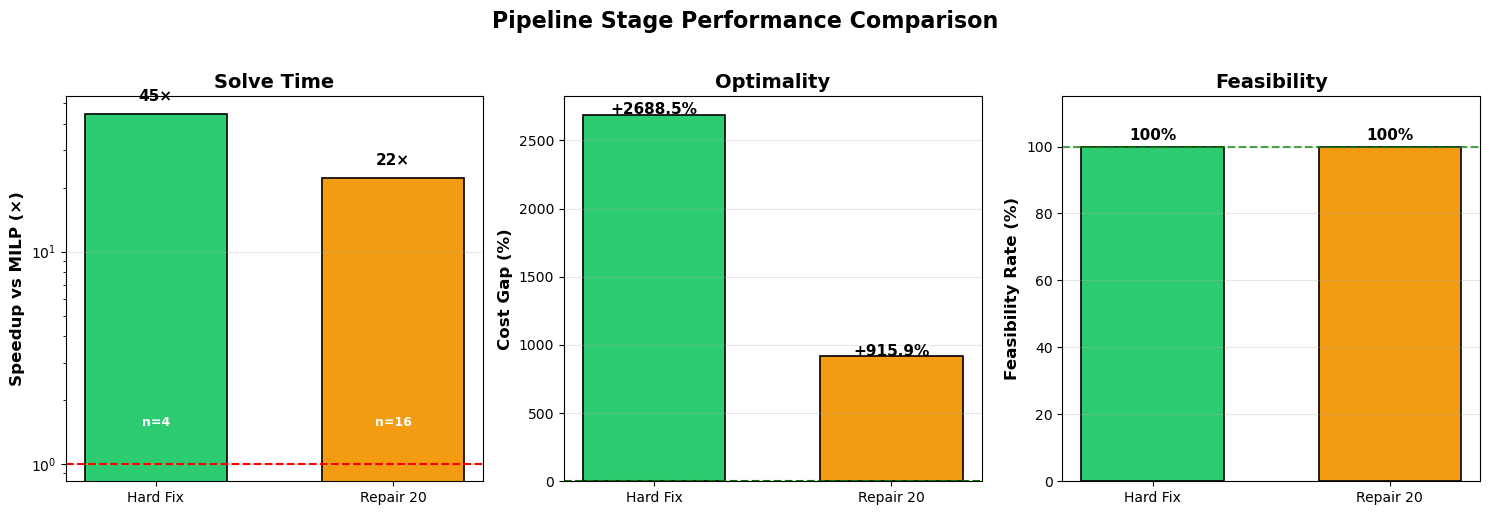

    stage  n   speedup    cost_gap  feasibility
 hard_fix  4 44.662423 2688.523810        100.0
repair_20 16 22.178291  915.924344        100.0


In [11]:
# ============================================================
# Stage Performance: 3 Charts (Time, Cost, Feasibility)
# ============================================================

stage_order = ['hard_fix', 'repair_20', 'repair_100', 'full_soft']
stage_order = [s for s in stage_order if s in df['stage_used'].values]
colors_stage = {'hard_fix': '#2ECC71', 'repair_20': '#F39C12', 'repair_100': '#E74C3C', 'full_soft': '#9B59B6'}

# Compute metrics per stage
slack_tol = 1.0
metrics = []
for stage in stage_order:
    mask = df['stage_used'] == stage
    n = mask.sum()
    metrics.append({
        'stage': stage,
        'n': n,
        'speedup': df.loc[mask, 'speedup'].mean(),
        'cost_gap': df.loc[mask, 'opt_gap_pct'].mean(),
        'feasibility': (df.loc[mask, 'slack_used'] <= slack_tol).mean() * 100,
    })

metrics_df = pd.DataFrame(metrics)
x = np.arange(len(stage_order))
width = 0.6

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. SPEEDUP
ax1 = axes[0]
bars1 = ax1.bar(x, metrics_df['speedup'], width, 
                color=[colors_stage[s] for s in stage_order], 
                edgecolor='black', linewidth=1.2)
ax1.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Break-even')
ax1.set_ylabel('Speedup vs MILP (×)', fontsize=12, fontweight='bold')
ax1.set_title('Solve Time', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([s.replace('_', ' ').title() for s in stage_order], fontsize=10)
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, axis='y')
for bar, val, n in zip(bars1, metrics_df['speedup'], metrics_df['n']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.15, 
             f'{val:.0f}×', ha='center', fontsize=11, fontweight='bold')
    ax1.text(bar.get_x() + bar.get_width()/2, 1.5, 
             f'n={n}', ha='center', fontsize=9, color='white', fontweight='bold')

# 2. COST GAP
ax2 = axes[1]
bars2 = ax2.bar(x, metrics_df['cost_gap'], width,
                color=[colors_stage[s] for s in stage_order],
                edgecolor='black', linewidth=1.2)
ax2.axhline(y=0, color='green', linestyle='--', linewidth=1.5, label='Optimal')
ax2.set_ylabel('Cost Gap (%)', fontsize=12, fontweight='bold')
ax2.set_title('Optimality', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([s.replace('_', ' ').title() for s in stage_order], fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, metrics_df['cost_gap']):
    ypos = bar.get_height() + (5 if val >= 0 else -12)
    ax2.text(bar.get_x() + bar.get_width()/2, ypos,
             f'{val:+.1f}%', ha='center', fontsize=11, fontweight='bold')

# 3. FEASIBILITY
ax3 = axes[2]
bars3 = ax3.bar(x, metrics_df['feasibility'], width,
                color=[colors_stage[s] for s in stage_order],
                edgecolor='black', linewidth=1.2)
ax3.axhline(y=100, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_ylabel('Feasibility Rate (%)', fontsize=12, fontweight='bold')
ax3.set_title('Feasibility', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels([s.replace('_', ' ').title() for s in stage_order], fontsize=10)
ax3.set_ylim(0, 115)
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars3, metrics_df['feasibility']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{val:.0f}%', ha='center', fontsize=11, fontweight='bold')

fig.suptitle('Pipeline Stage Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(BENCHMARK_ROOT / 'outputs' / 'pipeline_eval_stress' / 'stage_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
print(metrics_df[['stage', 'n', 'speedup', 'cost_gap', 'feasibility']].to_string(index=False))

---
# Analysis 1: Solve Time Breakdown (per SolveStage vs MILP)

C:\Users\Dell\AppData\Local\Temp\ipykernel_14360\3041232101.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(speedup_data, labels=stage_order, patch_artist=True)


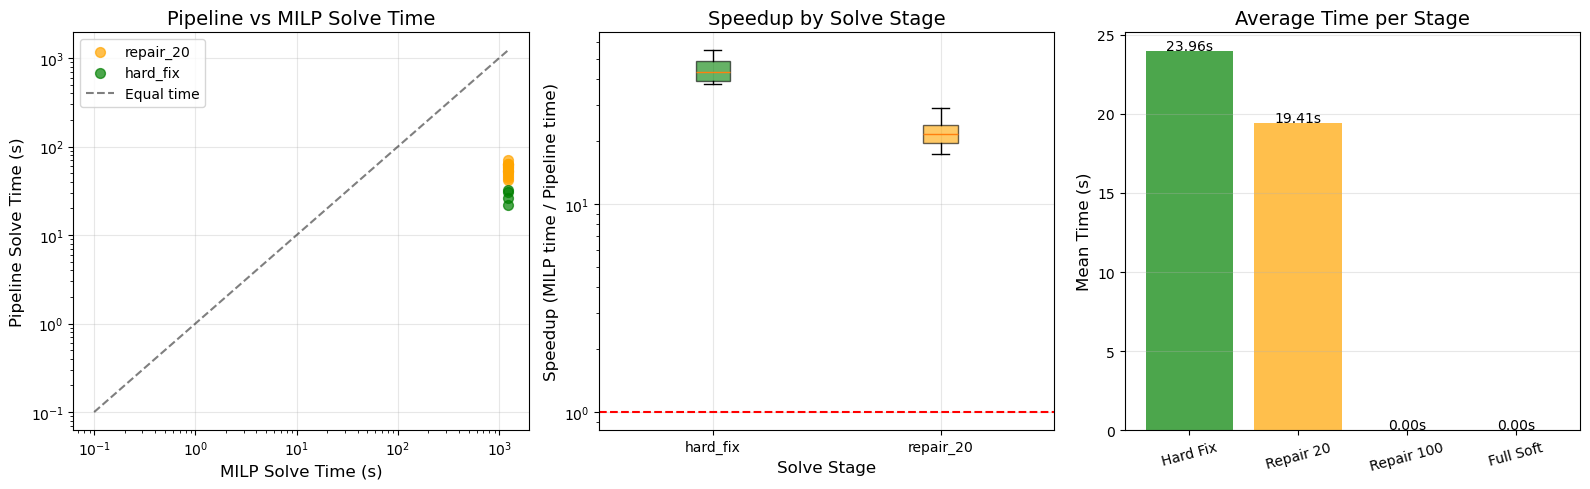


SOLVE TIME SUMMARY
Pipeline mean solve time: 50.24s (std: 13.66s)
MILP mean solve time: 1214.20s (std: 2.57s)

Mean speedup: 26.7x
Median speedup: 22.8x

Speedup by stage:
  hard_fix: 44.7x (n=4)
  repair_20: 22.2x (n=16)


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1a. Pipeline total time vs MILP time (log scale)
ax1 = axes[0]
stages = df['stage_used'].unique()
colors = {'hard_fix': 'green', 'repair_20': 'orange', 'repair_100': 'red', 'full_soft': 'purple', 'failed': 'gray'}

for stage in stages:
    mask = df['stage_used'] == stage
    ax1.scatter(df.loc[mask, 'milp_solve_time'], df.loc[mask, 'solve_time'], 
                label=stage, alpha=0.7, c=colors.get(stage, 'blue'), s=50)

max_time = max(df['milp_solve_time'].max(), df['solve_time'].max())
ax1.plot([0.1, max_time], [0.1, max_time], 'k--', alpha=0.5, label='Equal time')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('MILP Solve Time (s)', fontsize=12)
ax1.set_ylabel('Pipeline Solve Time (s)', fontsize=12)
ax1.set_title('Pipeline vs MILP Solve Time', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 1b. Speedup distribution by stage
ax2 = axes[1]
df['speedup'] = df['milp_solve_time'] / df['solve_time']
stage_order = ['hard_fix', 'repair_20', 'repair_100', 'full_soft']
stage_order = [s for s in stage_order if s in df['stage_used'].values]

speedup_data = [df.loc[df['stage_used'] == s, 'speedup'].values for s in stage_order]
bp = ax2.boxplot(speedup_data, labels=stage_order, patch_artist=True)
for patch, stage in zip(bp['boxes'], stage_order):
    patch.set_facecolor(colors.get(stage, 'blue'))
    patch.set_alpha(0.6)
ax2.axhline(y=1, color='red', linestyle='--', label='Break-even')
ax2.set_ylabel('Speedup (MILP time / Pipeline time)', fontsize=12)
ax2.set_xlabel('Solve Stage', fontsize=12)
ax2.set_title('Speedup by Solve Stage', fontsize=14)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# 1c. Per-stage time breakdown
ax3 = axes[2]
time_cols = ['time_hard_fix', 'time_repair_20', 'time_repair_100', 'time_full_soft']
time_means = df[time_cols].mean()
bars = ax3.bar(range(len(time_cols)), time_means.values, 
               color=['green', 'orange', 'red', 'purple'], alpha=0.7)
ax3.set_xticks(range(len(time_cols)))
ax3.set_xticklabels(['Hard Fix', 'Repair 20', 'Repair 100', 'Full Soft'], rotation=15)
ax3.set_ylabel('Mean Time (s)', fontsize=12)
ax3.set_title('Average Time per Stage', fontsize=14)
ax3.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, time_means.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{val:.2f}s', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(BENCHMARK_ROOT / 'outputs' / 'pipeline_eval' / 'solve_time_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary stats
print("\n" + "="*60)
print("SOLVE TIME SUMMARY")
print("="*60)
print(f"Pipeline mean solve time: {df['solve_time'].mean():.2f}s (std: {df['solve_time'].std():.2f}s)")
print(f"MILP mean solve time: {df['milp_solve_time'].mean():.2f}s (std: {df['milp_solve_time'].std():.2f}s)")
print(f"\nMean speedup: {df['speedup'].mean():.1f}x")
print(f"Median speedup: {df['speedup'].median():.1f}x")
print(f"\nSpeedup by stage:")
for stage in stage_order:
    mask = df['stage_used'] == stage
    print(f"  {stage}: {df.loc[mask, 'speedup'].mean():.1f}x (n={mask.sum()})")

---
# Analysis 2: Optimal Cost Breakdown (per SolveStage vs MILP)

C:\Users\Dell\AppData\Local\Temp\ipykernel_14360\2429520090.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(gap_data, labels=stage_order, patch_artist=True)


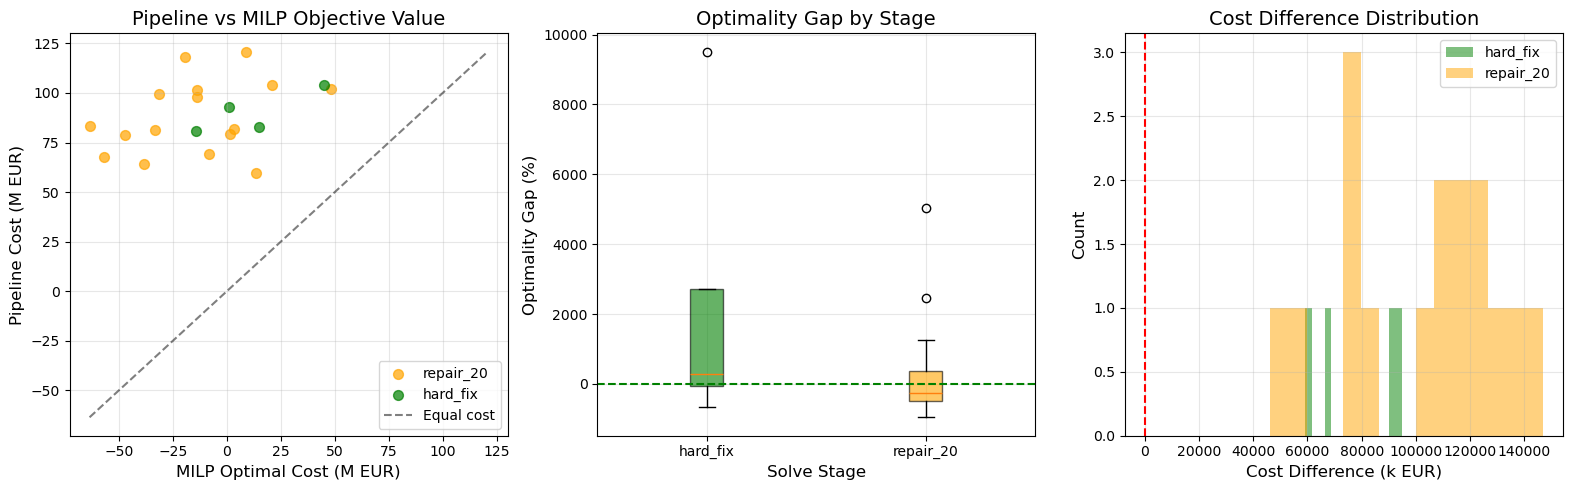


COST SUMMARY
Pipeline mean cost: 88.419 M EUR
MILP mean cost: -9.192 M EUR

Mean optimality gap: 700.99%
Median optimality gap: -224.71%

Gap by stage:
  hard_fix: 2358.52% (n=4)
  repair_20: 286.61% (n=16)


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 2a. Pipeline cost vs MILP cost
ax1 = axes[0]
for stage in stages:
    mask = df['stage_used'] == stage
    ax1.scatter(df.loc[mask, 'milp_objective'] / 1e6, df.loc[mask, 'objective_value'] / 1e6,
                label=stage, alpha=0.7, c=colors.get(stage, 'blue'), s=50)

max_cost = max(df['milp_objective'].max(), df['objective_value'].max()) / 1e6
min_cost = min(df['milp_objective'].min(), df['objective_value'].min()) / 1e6
ax1.plot([min_cost, max_cost], [min_cost, max_cost], 'k--', alpha=0.5, label='Equal cost')
ax1.set_xlabel('MILP Optimal Cost (M EUR)', fontsize=12)
ax1.set_ylabel('Pipeline Cost (M EUR)', fontsize=12)
ax1.set_title('Pipeline vs MILP Objective Value', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2b. Optimality gap distribution by stage
ax2 = axes[1]
df['opt_gap_pct'] = (df['objective_value'] - df['milp_objective']) / df['milp_objective'] * 100

gap_data = [df.loc[df['stage_used'] == s, 'opt_gap_pct'].values for s in stage_order]
bp = ax2.boxplot(gap_data, labels=stage_order, patch_artist=True)
for patch, stage in zip(bp['boxes'], stage_order):
    patch.set_facecolor(colors.get(stage, 'blue'))
    patch.set_alpha(0.6)
ax2.axhline(y=0, color='green', linestyle='--', label='Optimal')
ax2.set_ylabel('Optimality Gap (%)', fontsize=12)
ax2.set_xlabel('Solve Stage', fontsize=12)
ax2.set_title('Optimality Gap by Stage', fontsize=14)
ax2.grid(True, alpha=0.3)

# 2c. Cost difference histogram
ax3 = axes[2]
df['cost_diff'] = (df['objective_value'] - df['milp_objective']) / 1e3  # in k EUR
for stage in stage_order:
    mask = df['stage_used'] == stage
    ax3.hist(df.loc[mask, 'cost_diff'], bins=15, alpha=0.5, label=stage, color=colors.get(stage, 'blue'))
ax3.axvline(x=0, color='red', linestyle='--')
ax3.set_xlabel('Cost Difference (k EUR)', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_title('Cost Difference Distribution', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(BENCHMARK_ROOT / 'outputs' / 'pipeline_eval' / 'cost_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary stats
print("\n" + "="*60)
print("COST SUMMARY")
print("="*60)
print(f"Pipeline mean cost: {df['objective_value'].mean()/1e6:.3f} M EUR")
print(f"MILP mean cost: {df['milp_objective'].mean()/1e6:.3f} M EUR")
print(f"\nMean optimality gap: {df['opt_gap_pct'].mean():.2f}%")
print(f"Median optimality gap: {df['opt_gap_pct'].median():.2f}%")
print(f"\nGap by stage:")
for stage in stage_order:
    mask = df['stage_used'] == stage
    print(f"  {stage}: {df.loc[mask, 'opt_gap_pct'].mean():.2f}% (n={mask.sum()})")

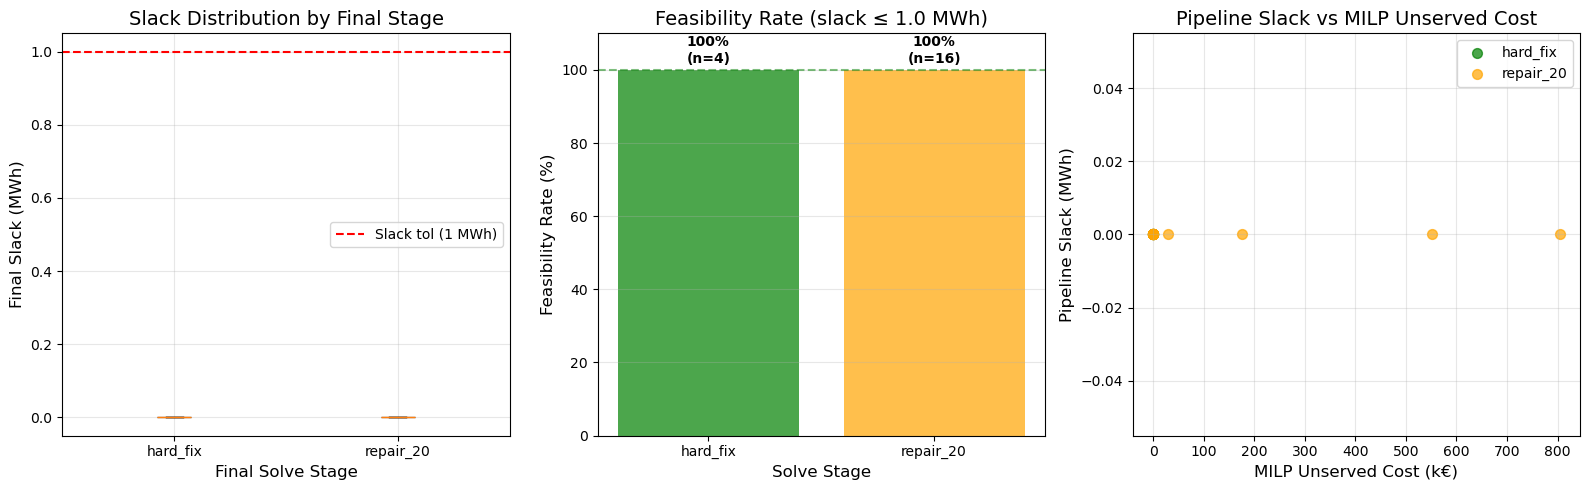


FEASIBILITY SUMMARY

Stage distribution:
  hard_fix    :   4 ( 20.0%) - mean slack: 0.00 MWh, max: 0.00 MWh
  repair_20   :  16 ( 80.0%) - mean slack: 0.00 MWh, max: 0.00 MWh

Overall feasibility rate (slack ≤ 1.0 MWh): 20/20 (100.0%)

Scenarios with slack > 0:
Empty DataFrame
Columns: [scenario_id, stage_used, slack_used]
Index: []


In [14]:
# ============================================================
# Analysis: Feasibility Analysis (Slack by SolveStage)
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Slack distribution by final stage
ax1 = axes[0]
stage_order = ['hard_fix', 'repair_20', 'repair_100', 'full_soft']
stage_order = [s for s in stage_order if s in df['stage_used'].values]

slack_data = [df.loc[df['stage_used'] == s, 'slack_used'].values for s in stage_order]
bp = ax1.boxplot(slack_data, tick_labels=stage_order, patch_artist=True)
for patch, stage in zip(bp['boxes'], stage_order):
    patch.set_facecolor(colors.get(stage, 'blue'))
    patch.set_alpha(0.6)
ax1.axhline(y=1.0, color='red', linestyle='--', label='Slack tol (1 MWh)')
ax1.set_ylabel('Final Slack (MWh)', fontsize=12)
ax1.set_xlabel('Final Solve Stage', fontsize=12)
ax1.set_title('Slack Distribution by Final Stage', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Feasibility rate by stage (slack <= tolerance)
ax2 = axes[1]
slack_tol = 1.0  # MWh
feasibility_rates = []
stage_counts = []
for stage in stage_order:
    mask = df['stage_used'] == stage
    n_total = mask.sum()
    n_feasible = (df.loc[mask, 'slack_used'] <= slack_tol).sum()
    rate = n_feasible / n_total * 100 if n_total > 0 else 0
    feasibility_rates.append(rate)
    stage_counts.append(n_total)

bars = ax2.bar(stage_order, feasibility_rates, color=[colors.get(s, 'blue') for s in stage_order], alpha=0.7)
ax2.axhline(y=100, color='green', linestyle='--', alpha=0.5)
ax2.set_ylabel('Feasibility Rate (%)', fontsize=12)
ax2.set_xlabel('Solve Stage', fontsize=12)
ax2.set_title(f'Feasibility Rate (slack ≤ {slack_tol} MWh)', fontsize=14)
ax2.set_ylim(0, 110)
ax2.grid(True, alpha=0.3, axis='y')
for bar, rate, n in zip(bars, feasibility_rates, stage_counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{rate:.0f}%\n(n={n})', ha='center', fontsize=10, fontweight='bold')

# 3. Pipeline slack vs MILP unserved cost
ax3 = axes[2]
# MILP unserved cost correlates with unserved energy
for stage in stage_order:
    mask = df['stage_used'] == stage
    ax3.scatter(df.loc[mask, 'milp_cost_unserved_energy'] / 1e3, df.loc[mask, 'slack_used'],
                label=stage, alpha=0.7, c=colors.get(stage, 'blue'), s=50)

ax3.set_xlabel('MILP Unserved Cost (k€)', fontsize=12)
ax3.set_ylabel('Pipeline Slack (MWh)', fontsize=12)
ax3.set_title('Pipeline Slack vs MILP Unserved Cost', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(BENCHMARK_ROOT / 'outputs' / 'pipeline_eval' / 'feasibility_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary stats
print("\n" + "="*60)
print("FEASIBILITY SUMMARY")
print("="*60)
print(f"\nStage distribution:")
for stage in stage_order:
    mask = df['stage_used'] == stage
    n = mask.sum()
    pct = n / len(df) * 100
    mean_slack = df.loc[mask, 'slack_used'].mean()
    max_slack = df.loc[mask, 'slack_used'].max()
    print(f"  {stage:12s}: {n:3d} ({pct:5.1f}%) - mean slack: {mean_slack:.2f} MWh, max: {max_slack:.2f} MWh")

n_feasible = (df['slack_used'] <= slack_tol).sum()
print(f"\nOverall feasibility rate (slack ≤ {slack_tol} MWh): {n_feasible}/{len(df)} ({n_feasible/len(df)*100:.1f}%)")

print(f"\nScenarios with slack > 0:")
high_slack = df[df['slack_used'] > 0][['scenario_id', 'stage_used', 'slack_used']].sort_values('slack_used', ascending=False)
print(high_slack.to_string(index=False))

---
# Analysis 3: Dispatch Comparison (Pipeline LP continuous_vars vs MILP)

In [15]:
def extract_milp_dispatch(report):
    """Extract dispatch arrays from MILP report detail section."""
    dispatch = {}
    
    detail = report.get('detail', {})
    if not detail:
        return dispatch
    
    # Mapping from detail keys to standard names
    key_mapping = {
        'thermal': 'p_thermal',
        'nuclear': 'p_nuclear', 
        'solar': 'p_solar',
        'wind': 'p_wind',
        'hydro_release': 'h_release',
        'hydro_ror': 'hydro_ror',
        'battery_discharge': 'b_discharge',
        'battery_charge': 'b_charge',
        'pumped_discharge': 'pumped_discharge',
        'pumped_charge': 'pumped_charge',
        'demand_response': 'dr_shed',
        'unserved': 'unserved',
        'demand': 'demand',
        'solar_spill': 'spill_solar',
        'wind_spill': 'spill_wind',
        'hydro_spill': 'h_spill',  # Map to pipeline naming
        'overgen_spill': 'overgen_spill',
    }
    
    for detail_key, std_key in key_mapping.items():
        if detail_key in detail:
            zone_data = detail[detail_key]
            if isinstance(zone_data, dict):
                arrays = [np.array(v) for v in zone_data.values() if isinstance(v, list)]
                if arrays:
                    dispatch[std_key] = np.sum(arrays, axis=0)
    
    # Handle net_import
    if 'net_import' in detail:
        ni_data = detail['net_import']
        if isinstance(ni_data, dict):
            if 'values' in ni_data:
                dispatch['net_import'] = np.array(ni_data['values'])
            else:
                arrays = [np.array(v) for v in ni_data.values() if isinstance(v, list)]
                if arrays:
                    dispatch['net_import'] = np.sum(arrays, axis=0)
    
    return dispatch

def extract_pipeline_dispatch(row):
    """Extract dispatch from pipeline result continuous_vars."""
    if 'continuous_vars' in row and row['continuous_vars']:
        return row['continuous_vars']
    if '_lp_result' in row and row['_lp_result'] is not None:
        lp_res = row['_lp_result']
        if hasattr(lp_res, 'continuous_vars'):
            return lp_res.continuous_vars
        elif isinstance(lp_res, dict) and 'continuous_vars' in lp_res:
            return lp_res['continuous_vars']
    return {}

def get_stacked_dispatch_data(dispatch_dict):
    """Extract and aggregate dispatch data for stacked plot."""
    # Generation sources
    gen_components = [
        ('p_nuclear', 'Nuclear', '#FF6B6B'),
        ('p_thermal', 'Thermal', '#4ECDC4'),
        ('p_solar', 'Solar', '#FFE66D'),
        ('p_wind', 'Wind', '#95E1D3'),
        ('h_release', 'Hydro Reservoir', '#5D9CEC'),
        ('hydro_ror', 'Hydro RoR', '#3498DB'),
        ('b_discharge', 'Battery Discharge', '#A29BFE'),
        ('pumped_discharge', 'Pumped Discharge', '#74B9FF'),
        ('dr_shed', 'Demand Response', '#FD79A8'),
    ]
    
    # Charging loads
    charging_components = [
        ('b_charge', 'Battery Charge', '#7B68EE'),
        ('pumped_charge', 'Pumped Charge', '#4169E1'),
    ]
    
    data = {}
    charging = {}
    n_timesteps = 24
    
    for var_name, label, color in gen_components:
        if var_name in dispatch_dict:
            arr = dispatch_dict[var_name]
            if hasattr(arr, 'ndim') and arr.ndim == 2:
                total = np.sum(arr, axis=0)
            else:
                total = np.array(arr).flatten() if hasattr(arr, '__iter__') else np.array([arr])
            if len(total) > 0:
                n_timesteps = len(total)
                data[label] = {'values': total, 'color': color}
    
    for var_name, label, color in charging_components:
        if var_name in dispatch_dict:
            arr = dispatch_dict[var_name]
            if hasattr(arr, 'ndim') and arr.ndim == 2:
                total = np.sum(arr, axis=0)
            else:
                total = np.array(arr).flatten() if hasattr(arr, '__iter__') else np.array([arr])
            if len(total) > 0:
                charging[label] = {'values': total, 'color': color}
    
    # Extract demand
    demand = None
    if 'demand' in dispatch_dict:
        arr = dispatch_dict['demand']
        if hasattr(arr, 'ndim') and arr.ndim == 2:
            demand = np.sum(arr, axis=0)
        else:
            demand = np.array(arr).flatten() if hasattr(arr, '__iter__') else None
    
    # Extract unserved and spills (using consistent naming: h_spill for hydro)
    extras = {}
    extra_keys = ['unserved', 'spill_solar', 'spill_wind', 'overgen_spill', 'h_spill']
    for key in extra_keys:
        if key in dispatch_dict:
            arr = dispatch_dict[key]
            if hasattr(arr, 'ndim') and arr.ndim == 2:
                extras[key] = np.sum(arr, axis=0)
            else:
                extras[key] = np.array(arr).flatten() if hasattr(arr, '__iter__') else None
    
    return data, charging, n_timesteps, demand, extras

# Select scenarios for detailed comparison
sample_scenarios = df.sample(min(3, len(df)))['scenario_id'].tolist()
print(f"Comparing dispatch for scenarios: {sample_scenarios}")

# DEBUG: Check keys
test_row = df[df['scenario_id'] == sample_scenarios[0]].iloc[0]
test_dispatch = extract_pipeline_dispatch(test_row)
print(f"\nPipeline keys: {list(test_dispatch.keys())}")

test_milp = extract_milp_dispatch(milp_reports.get(sample_scenarios[0], {}))
print(f"MILP keys: {list(test_milp.keys())}")

Comparing dispatch for scenarios: ['scenario_00014', 'scenario_00019', 'scenario_00008']

Pipeline keys: ['p_thermal', 'p_nuclear', 'p_solar', 'p_wind', 'b_charge', 'b_discharge', 'b_soc', 'pumped_charge', 'pumped_discharge', 'pumped_level', 'h_release', 'h_level', 'dr_shed', 'unserved', 'spill_solar', 'spill_wind', 'overgen_spill', 'u_thermal']
MILP keys: ['p_thermal', 'p_nuclear', 'p_solar', 'p_wind', 'h_release', 'hydro_ror', 'b_discharge', 'b_charge', 'pumped_discharge', 'pumped_charge', 'dr_shed', 'unserved', 'demand', 'spill_solar', 'spill_wind', 'h_spill', 'overgen_spill', 'net_import']


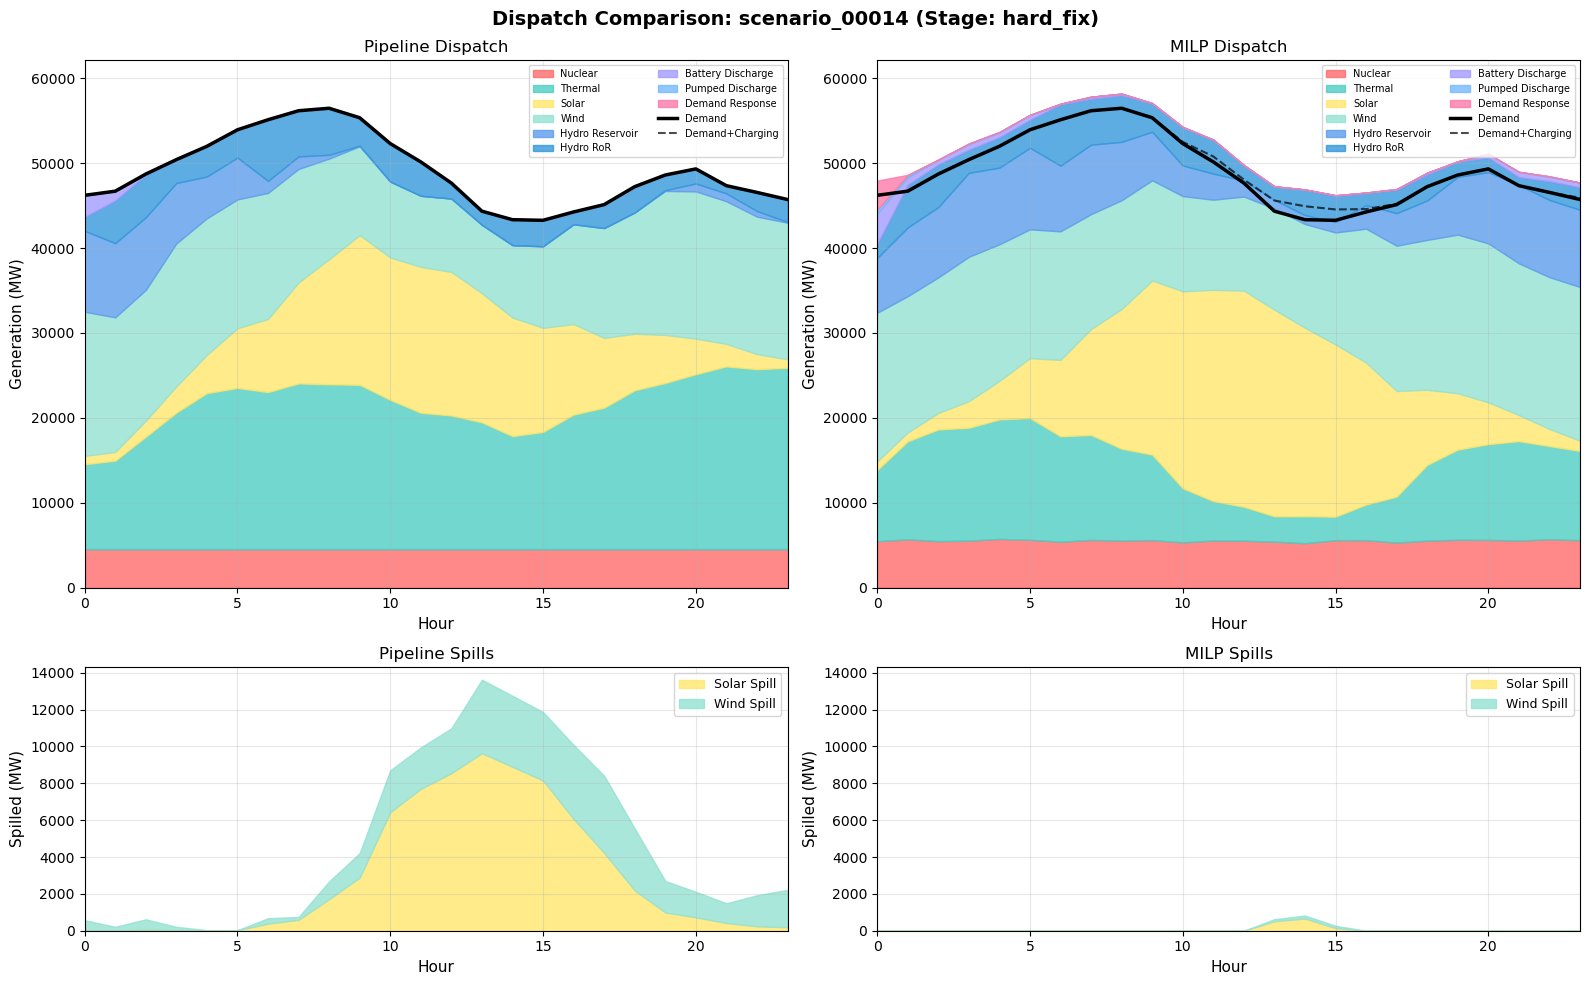


scenario_00014 Summary:
  Pipeline: Gen=1176236 MWh, Charge=0 MWh, Spill=112395 MWh, Unserved=0.0 MWh
  MILP: Gen=1224839 MWh, Charge=6058 MWh, Spill=1721 MWh, Unserved=0.0 MWh
  Total demand: 1176236 MWh


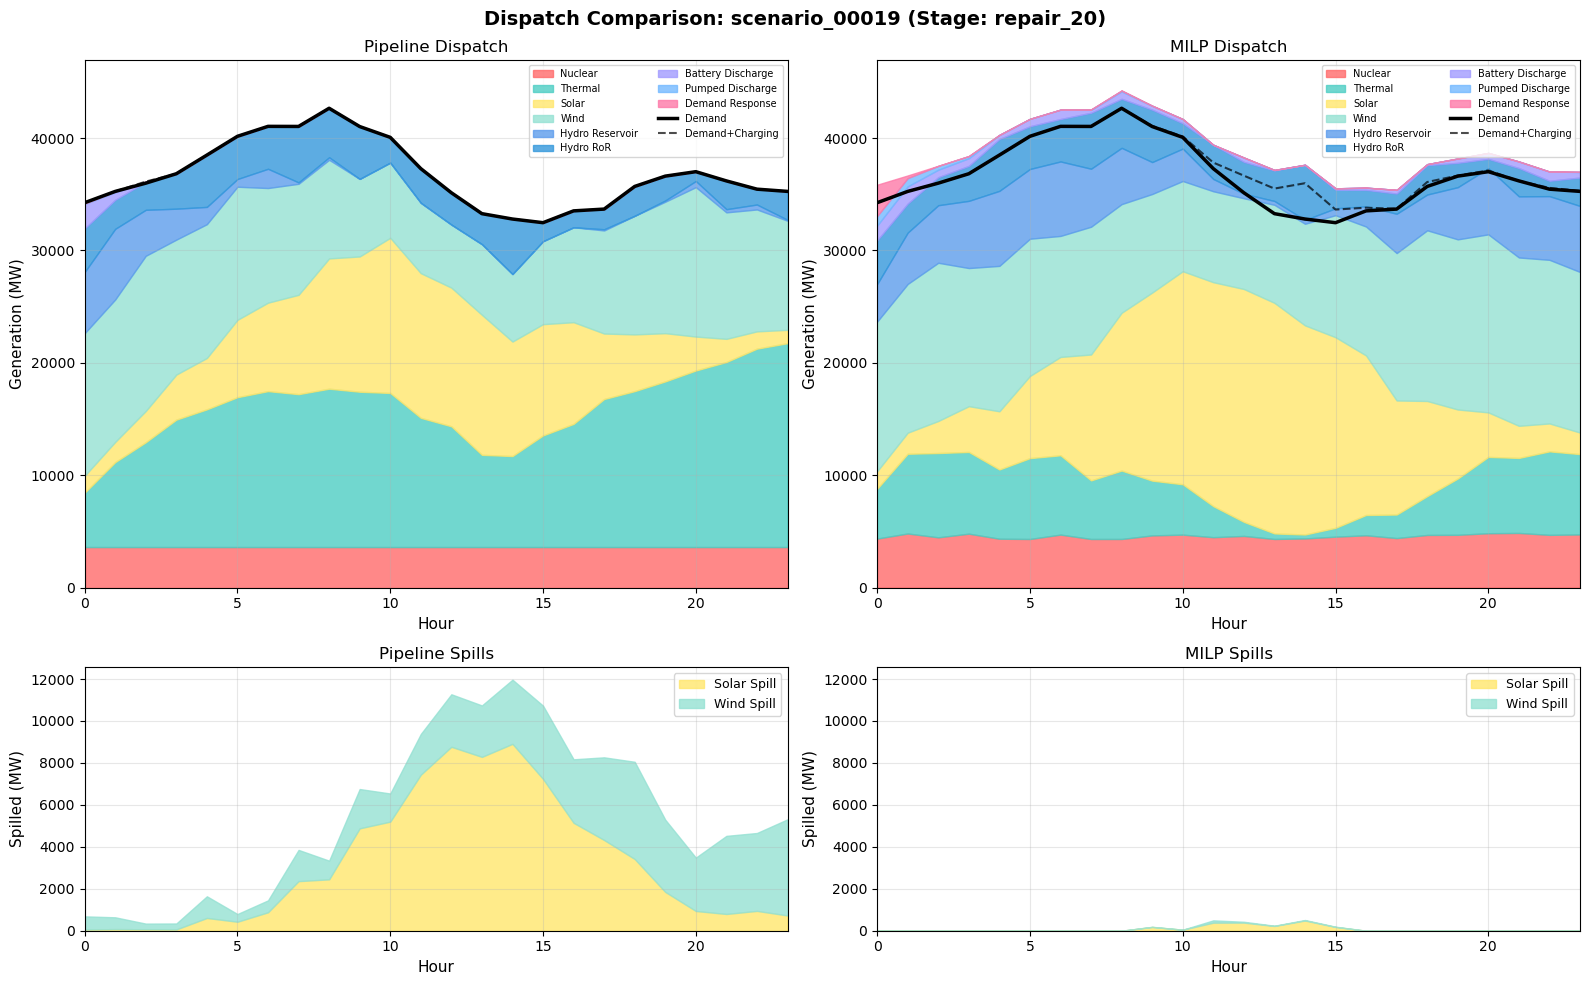


scenario_00019 Summary:
  Pipeline: Gen=881311 MWh, Charge=140 MWh, Spill=128248 MWh, Unserved=0.0 MWh
  MILP: Gen=929808 MWh, Charge=9808 MWh, Spill=2097 MWh, Unserved=0.0 MWh
  Total demand: 881171 MWh


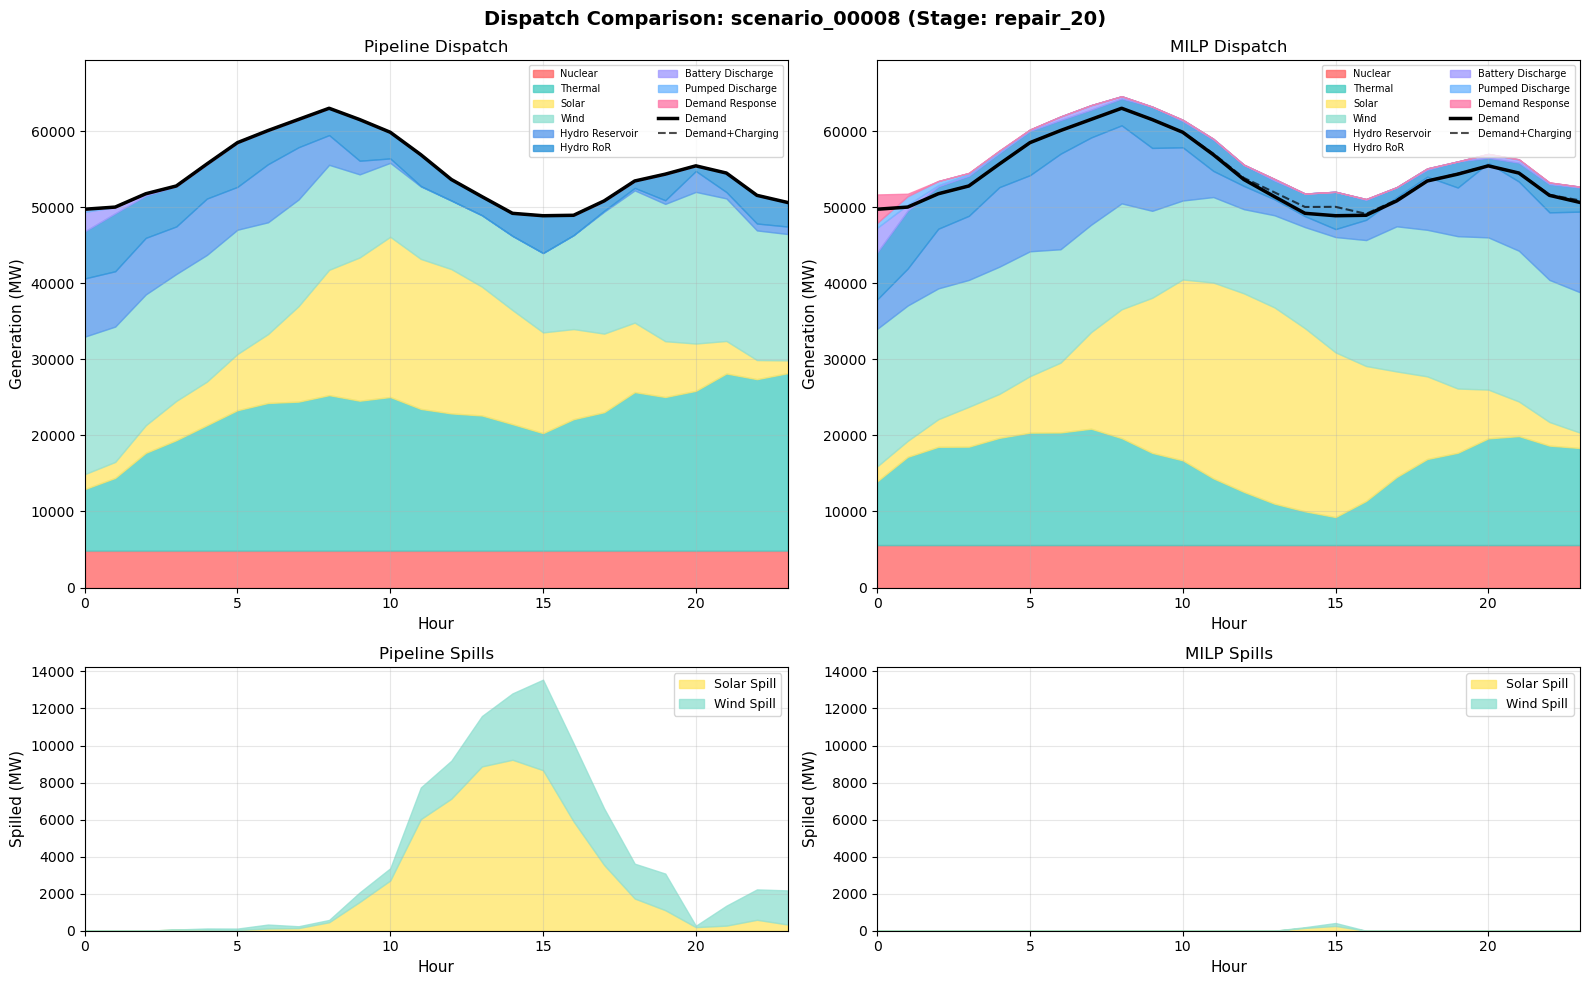


scenario_00008 Summary:
  Pipeline: Gen=1304696 MWh, Charge=0 MWh, Spill=91230 MWh, Unserved=0.0 MWh
  MILP: Gen=1350443 MWh, Charge=3659 MWh, Spill=607 MWh, Unserved=0.0 MWh
  Total demand: 1304696 MWh


In [16]:
# Plot stacked dispatch comparison with proper power balance
for sc_id in sample_scenarios[:3]:
    row = df[df['scenario_id'] == sc_id].iloc[0]
    
    # Get dispatches
    pipeline_dispatch = extract_pipeline_dispatch(row)
    milp_report = milp_reports.get(sc_id, {})
    milp_dispatch = extract_milp_dispatch(milp_report)
    
    if not pipeline_dispatch:
        print(f"No pipeline continuous_vars for {sc_id}")
        continue
    
    # Copy hydro_ror from MILP to pipeline (same input data)
    if 'hydro_ror' in milp_dispatch and 'hydro_ror' not in pipeline_dispatch:
        pipeline_dispatch['hydro_ror'] = milp_dispatch['hydro_ror']
    
    # Get stacked data
    pipeline_gen, pipeline_charge, n_t, _, pipeline_extras = get_stacked_dispatch_data(pipeline_dispatch)
    milp_gen, milp_charge, _, milp_demand, milp_extras = get_stacked_dispatch_data(milp_dispatch)
    
    hours = np.arange(n_t)
    
    # Create 2x2 figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), height_ratios=[2, 1])
    fig.suptitle(f'Dispatch Comparison: {sc_id} (Stage: {row["stage_used"]})', fontsize=14, fontweight='bold')
    
    # ===== TOP LEFT: Pipeline Dispatch =====
    ax1 = axes[0, 0]
    bottom = np.zeros(n_t)
    for label, data in pipeline_gen.items():
        values = data['values']
        if len(values) == n_t:
            ax1.fill_between(hours, bottom, bottom + values, label=label, color=data['color'], alpha=0.8)
            bottom += values
    
    # Add unserved on top
    if 'unserved' in pipeline_extras and pipeline_extras['unserved'] is not None:
        unserved = pipeline_extras['unserved']
        if len(unserved) == n_t and np.sum(unserved) > 0:
            ax1.fill_between(hours, bottom, bottom + unserved, label='Unserved', color='#2D3436', alpha=0.9)
            bottom += unserved
    
    # Demand + charging line
    total_load = np.zeros(n_t)
    if milp_demand is not None and len(milp_demand) == n_t:
        total_load = milp_demand.copy()
    for label, data in pipeline_charge.items():
        if len(data['values']) == n_t:
            total_load += data['values']
    
    if milp_demand is not None:
        ax1.plot(hours, milp_demand, 'k-', linewidth=2.5, label='Demand', zorder=10)
        ax1.plot(hours, total_load, 'k--', linewidth=1.5, label='Demand+Charging', zorder=9, alpha=0.7)
    
    ax1.set_xlabel('Hour', fontsize=11)
    ax1.set_ylabel('Generation (MW)', fontsize=11)
    ax1.set_title('Pipeline Dispatch', fontsize=12)
    ax1.legend(loc='upper right', fontsize=7, ncol=2)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, n_t-1)
    ax1.set_ylim(bottom=0)
    
    # ===== TOP RIGHT: MILP Dispatch =====
    ax2 = axes[0, 1]
    if milp_gen:
        bottom = np.zeros(n_t)
        for label, data in milp_gen.items():
            values = data['values']
            if len(values) == n_t:
                ax2.fill_between(hours, bottom, bottom + values, label=label, color=data['color'], alpha=0.8)
                bottom += values
        
        if 'unserved' in milp_extras and milp_extras['unserved'] is not None:
            unserved = milp_extras['unserved']
            if len(unserved) == n_t and np.sum(unserved) > 0:
                ax2.fill_between(hours, bottom, bottom + unserved, label='Unserved', color='#2D3436', alpha=0.9)
                bottom += unserved
        
        milp_total_load = np.zeros(n_t)
        if milp_demand is not None and len(milp_demand) == n_t:
            milp_total_load = milp_demand.copy()
        for label, data in milp_charge.items():
            if len(data['values']) == n_t:
                milp_total_load += data['values']
        
        if milp_demand is not None:
            ax2.plot(hours, milp_demand, 'k-', linewidth=2.5, label='Demand', zorder=10)
            ax2.plot(hours, milp_total_load, 'k--', linewidth=1.5, label='Demand+Charging', zorder=9, alpha=0.7)
        
        ax2.legend(loc='upper right', fontsize=7, ncol=2)
    else:
        ax2.text(0.5, 0.5, 'No MILP dispatch data', ha='center', va='center', transform=ax2.transAxes)
    
    ax2.set_xlabel('Hour', fontsize=11)
    ax2.set_ylabel('Generation (MW)', fontsize=11)
    ax2.set_title('MILP Dispatch', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, n_t-1)
    ax2.set_ylim(bottom=0)
    
    # Match y-axis
    max_y = max(axes[0, 0].get_ylim()[1], axes[0, 1].get_ylim()[1])
    if milp_demand is not None:
        max_y = max(max_y, np.max(total_load) * 1.1 if len(total_load) > 0 else max_y)
    axes[0, 0].set_ylim(0, max_y)
    axes[0, 1].set_ylim(0, max_y)
    
    # ===== BOTTOM LEFT: Pipeline Spills =====
    ax3 = axes[1, 0]
    spill_config = [
        ('spill_solar', 'Solar Spill', '#FFE66D'),
        ('spill_wind', 'Wind Spill', '#95E1D3'),
        ('h_spill', 'Hydro Spill', '#5D9CEC'),
        ('overgen_spill', 'Overgen Spill', '#636E72'),
    ]
    
    bottom_spill = np.zeros(n_t)
    has_spill_p = False
    for key, label, color in spill_config:
        if key in pipeline_extras and pipeline_extras[key] is not None:
            vals = pipeline_extras[key]
            if len(vals) == n_t and np.sum(vals) > 0:
                ax3.fill_between(hours, bottom_spill, bottom_spill + vals, label=label, color=color, alpha=0.8)
                bottom_spill += vals
                has_spill_p = True
    
    if not has_spill_p:
        ax3.text(0.5, 0.5, 'No spill data', ha='center', va='center', transform=ax3.transAxes, fontsize=10, alpha=0.5)
    else:
        ax3.legend(loc='upper right', fontsize=9)
    
    ax3.set_xlabel('Hour', fontsize=11)
    ax3.set_ylabel('Spilled (MW)', fontsize=11)
    ax3.set_title('Pipeline Spills', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, n_t-1)
    ax3.set_ylim(bottom=0)
    
    # ===== BOTTOM RIGHT: MILP Spills =====
    ax4 = axes[1, 1]
    bottom_spill = np.zeros(n_t)
    has_spill_m = False
    for key, label, color in spill_config:
        if key in milp_extras and milp_extras[key] is not None:
            vals = milp_extras[key]
            if len(vals) == n_t and np.sum(vals) > 0:
                ax4.fill_between(hours, bottom_spill, bottom_spill + vals, label=label, color=color, alpha=0.8)
                bottom_spill += vals
                has_spill_m = True
    
    if not has_spill_m:
        ax4.text(0.5, 0.5, 'No spill data', ha='center', va='center', transform=ax4.transAxes, fontsize=10, alpha=0.5)
    else:
        ax4.legend(loc='upper right', fontsize=9)
    
    ax4.set_xlabel('Hour', fontsize=11)
    ax4.set_ylabel('Spilled (MW)', fontsize=11)
    ax4.set_title('MILP Spills', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, n_t-1)
    ax4.set_ylim(bottom=0)
    
    # Match spill y-axis
    max_y_spill = max(axes[1, 0].get_ylim()[1], axes[1, 1].get_ylim()[1])
    if max_y_spill > 0:
        axes[1, 0].set_ylim(0, max_y_spill)
        axes[1, 1].set_ylim(0, max_y_spill)
    
    plt.tight_layout()
    plt.savefig(BENCHMARK_ROOT / 'outputs' / 'pipeline_eval' / f'dispatch_full_{sc_id}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary
    pipeline_total_gen = sum(np.sum(d['values']) for d in pipeline_gen.values())
    pipeline_total_charge = sum(np.sum(d['values']) for d in pipeline_charge.values())
    pipeline_total_spill = sum(np.sum(v) for k, v in pipeline_extras.items() if v is not None and 'spill' in k)
    pipeline_unserved = np.sum(pipeline_extras.get('unserved', 0)) if pipeline_extras.get('unserved') is not None else 0
    
    print(f"\n{sc_id} Summary:")
    print(f"  Pipeline: Gen={pipeline_total_gen:.0f} MWh, Charge={pipeline_total_charge:.0f} MWh, Spill={pipeline_total_spill:.0f} MWh, Unserved={pipeline_unserved:.1f} MWh")
    
    if milp_gen:
        milp_total_gen = sum(np.sum(d['values']) for d in milp_gen.values())
        milp_total_charge = sum(np.sum(d['values']) for d in milp_charge.values())
        milp_total_spill = sum(np.sum(v) for k, v in milp_extras.items() if v is not None and 'spill' in k)
        milp_unserved = np.sum(milp_extras.get('unserved', 0)) if milp_extras.get('unserved') is not None else 0
        print(f"  MILP: Gen={milp_total_gen:.0f} MWh, Charge={milp_total_charge:.0f} MWh, Spill={milp_total_spill:.0f} MWh, Unserved={milp_unserved:.1f} MWh")
    
    if milp_demand is not None:
        print(f"  Total demand: {np.sum(milp_demand):.0f} MWh")

In [17]:
# Aggregate dispatch comparison across all scenarios
print("\n" + "="*60)
print("AGGREGATE DISPATCH COMPARISON")
print("="*60)

# Calculate total generation by type across all scenarios
agg_pipeline = {'thermal': 0, 'nuclear': 0, 'solar': 0, 'wind': 0, 'battery': 0, 'unserved': 0}

for _, row in df.iterrows():
    dispatch = extract_pipeline_dispatch(row)
    if dispatch:
        agg_pipeline['thermal'] += np.sum(dispatch.get('p_thermal', 0))
        agg_pipeline['nuclear'] += np.sum(dispatch.get('p_nuclear', 0))
        agg_pipeline['solar'] += np.sum(dispatch.get('p_solar', 0))
        agg_pipeline['wind'] += np.sum(dispatch.get('p_wind', 0))
        agg_pipeline['battery'] += np.sum(dispatch.get('b_discharge', 0))
        agg_pipeline['unserved'] += np.sum(dispatch.get('unserved', 0))

print("\nPipeline Total Generation (GWh):")
for key, val in agg_pipeline.items():
    print(f"  {key}: {val/1e3:.1f} GWh")


AGGREGATE DISPATCH COMPARISON

Pipeline Total Generation (GWh):
  thermal: 6887.8 GWh
  nuclear: 1879.2 GWh
  solar: 3769.7 GWh
  wind: 5530.6 GWh
  battery: 53.8 GWh
  unserved: 0.0 GWh


---
# Analysis 4: Cost Components Breakdown

Cost components: ['milp_cost_thermal_fuel', 'milp_cost_nuclear_fuel', 'milp_cost_demand_response', 'milp_cost_unserved_energy', 'milp_cost_solar_spill', 'milp_cost_wind_spill', 'milp_cost_hydro_spill', 'milp_cost_overgen_spill', 'milp_cost_imports', 'milp_cost_exports', 'milp_cost_battery_cycle', 'milp_cost_pumped_cycle']


ValueError: Wedge sizes 'x' must be non negative values

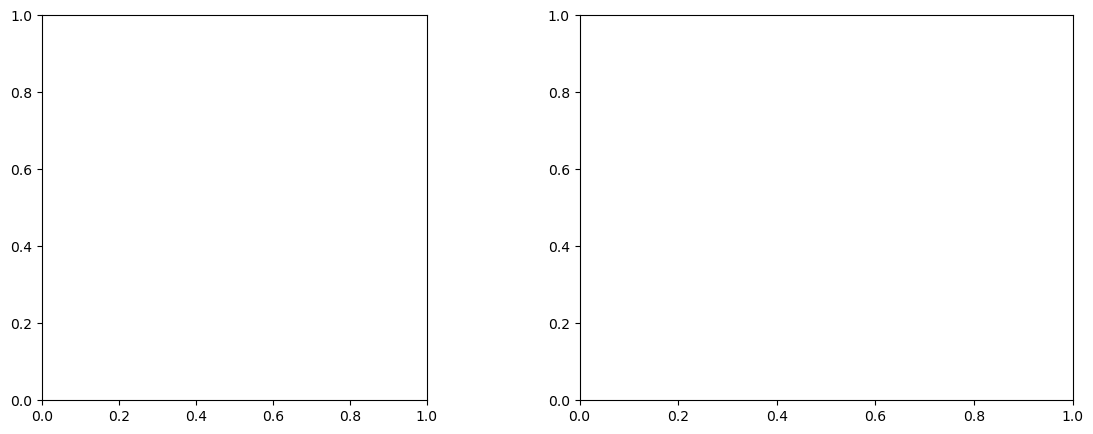

In [18]:
# Get cost component columns from MILP
cost_cols = [c for c in df.columns if c.startswith('milp_cost_')]
print(f"Cost components: {cost_cols}")

# Calculate mean cost components
cost_means = df[cost_cols].mean().sort_values(ascending=False)
cost_means.index = [c.replace('milp_cost_', '') for c in cost_means.index]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 4a. MILP cost breakdown
ax1 = axes[0]
colors_cost = plt.cm.Set3(np.linspace(0, 1, len(cost_means)))
wedges, texts, autotexts = ax1.pie(cost_means.values, labels=cost_means.index, 
                                    autopct=lambda pct: f'{pct:.1f}%' if pct > 2 else '',
                                    colors=colors_cost, startangle=90)
ax1.set_title('MILP Cost Components (Mean)', fontsize=14)

# 4b. Cost components by stage
ax2 = axes[1]
top_costs = cost_means.head(5).index.tolist()
x = np.arange(len(stage_order))
width = 0.15

for i, cost_name in enumerate(top_costs):
    cost_col = f'milp_cost_{cost_name}'
    means = [df.loc[df['stage_used'] == s, cost_col].mean() / 1e6 for s in stage_order]
    ax2.bar(x + i*width, means, width, label=cost_name)

ax2.set_xlabel('Solve Stage', fontsize=12)
ax2.set_ylabel('Cost (M EUR)', fontsize=12)
ax2.set_title('Top Cost Components by Stage', fontsize=14)
ax2.set_xticks(x + width * 2)
ax2.set_xticklabels(stage_order)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(BENCHMARK_ROOT / 'outputs' / 'pipeline_eval' / 'cost_components.png', dpi=150, bbox_inches='tight')
plt.show()

# Print cost breakdown
print("\n" + "="*60)
print("COST COMPONENTS BREAKDOWN (Mean)")
print("="*60)
for comp, val in cost_means.items():
    print(f"  {comp}: {val/1e6:.3f} M EUR ({val/cost_means.sum()*100:.1f}%)")

---
# Analysis 5: Focus on hard_fix, repair_20, repair_100 Solutions

In [19]:
# Detailed analysis for each stage
focus_stages = ['hard_fix', 'repair_20', 'repair_100']

print("="*80)
print("DETAILED STAGE ANALYSIS")
print("="*80)

for stage in focus_stages:
    df_stage = df[df['stage_used'] == stage]
    n = len(df_stage)
    
    if n == 0:
        print(f"\n{stage.upper()}: No scenarios")
        continue
    
    print(f"\n{'='*40}")
    print(f"{stage.upper()} (n={n}, {n/len(df)*100:.1f}% of total)")
    print(f"{'='*40}")
    
    print(f"\nSolve Time:")
    print(f"  Pipeline: {df_stage['solve_time'].mean():.2f}s ± {df_stage['solve_time'].std():.2f}s")
    print(f"  MILP: {df_stage['milp_solve_time'].mean():.2f}s ± {df_stage['milp_solve_time'].std():.2f}s")
    print(f"  Speedup: {df_stage['speedup'].mean():.1f}x (median: {df_stage['speedup'].median():.1f}x)")
    
    print(f"\nCost:")
    print(f"  Pipeline: {df_stage['objective_value'].mean()/1e6:.3f} M EUR")
    print(f"  MILP: {df_stage['milp_objective'].mean()/1e6:.3f} M EUR")
    print(f"  Gap: {df_stage['opt_gap_pct'].mean():.2f}% ± {df_stage['opt_gap_pct'].std():.2f}%")
    
    print(f"\nSlack & Deviations:")
    print(f"  Slack used: {df_stage['slack_used'].mean():.2f} MWh")
    print(f"  Flips: {df_stage['n_flips'].mean():.1f}")

DETAILED STAGE ANALYSIS

HARD_FIX (n=4, 20.0% of total)

Solve Time:
  Pipeline: 27.76s ± 4.54s
  MILP: 1213.63s ± 1.79s
  Speedup: 44.7x (median: 42.9x)

Cost:
  Pipeline: 90.086 M EUR
  MILP: 11.668 M EUR
  Gap: 2358.52% ± 4791.13%

Slack & Deviations:
  Slack used: 0.00 MWh
  Flips: 0.0

REPAIR_20 (n=16, 80.0% of total)

Solve Time:
  Pipeline: 55.86s ± 7.99s
  MILP: 1214.34s ± 2.75s
  Speedup: 22.2x (median: 21.7x)

Cost:
  Pipeline: 88.002 M EUR
  MILP: -14.407 M EUR
  Gap: 286.61% ± 1534.06%

Slack & Deviations:
  Slack used: 0.00 MWh
  Flips: 1.2

REPAIR_100: No scenarios


C:\Users\Dell\AppData\Local\Temp\ipykernel_14360\789853079.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(data_time, labels=labels_time, patch_artist=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_14360\789853079.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(data_gap, labels=labels_time, patch_artist=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_14360\789853079.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax3.boxplot(data_slack, labels=labels_time, patch_artist=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_14360\789853079.py:42: MatplotlibDeprecatio

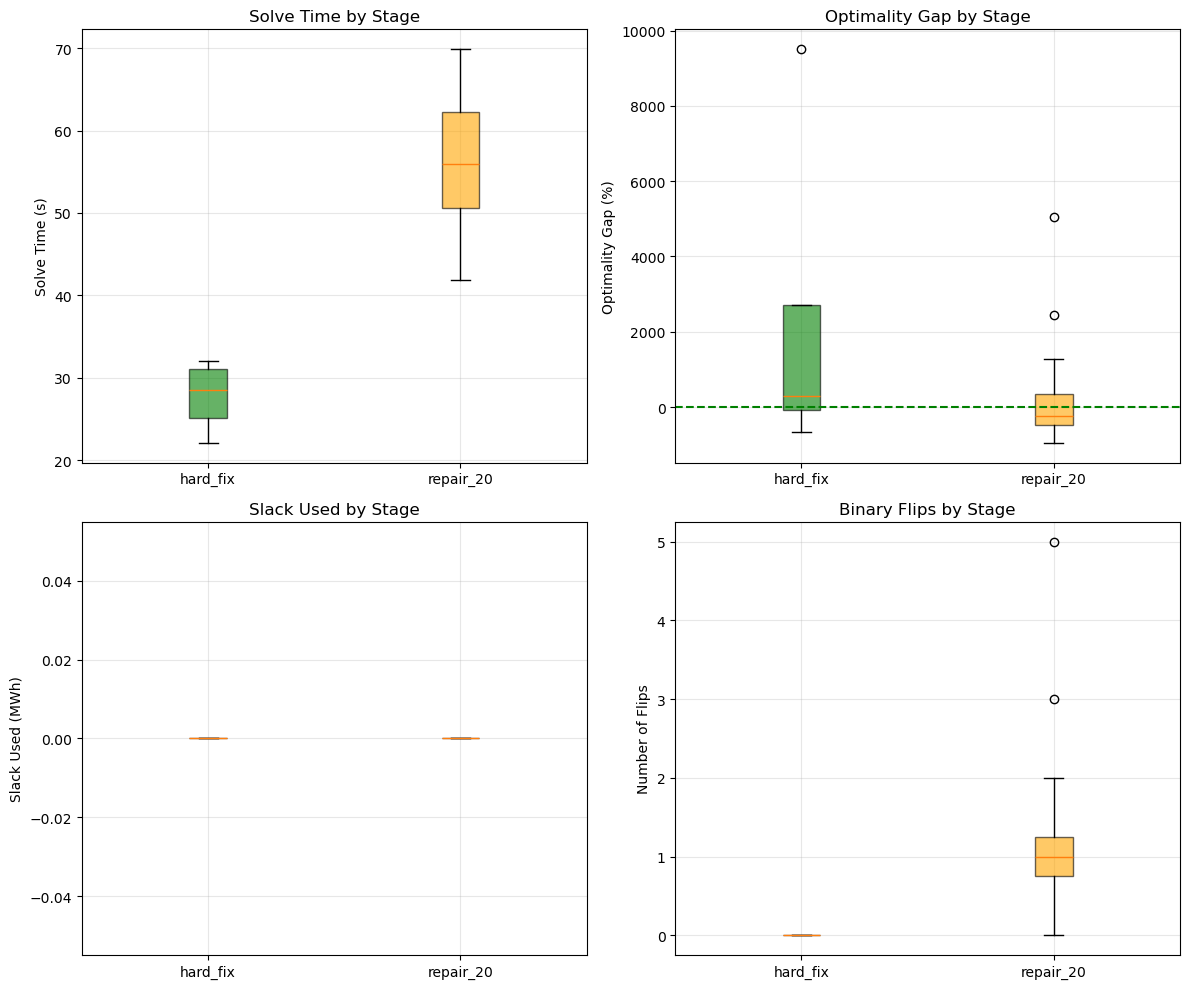

In [20]:
# Comparison visualization for focus stages
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 5a. Solve time comparison
ax1 = axes[0, 0]
data_time = [df.loc[df['stage_used'] == s, 'solve_time'].values for s in focus_stages if s in df['stage_used'].values]
labels_time = [s for s in focus_stages if s in df['stage_used'].values]
bp1 = ax1.boxplot(data_time, labels=labels_time, patch_artist=True)
for patch, stage in zip(bp1['boxes'], labels_time):
    patch.set_facecolor(colors.get(stage, 'blue'))
    patch.set_alpha(0.6)
ax1.set_ylabel('Solve Time (s)')
ax1.set_title('Solve Time by Stage')
ax1.grid(True, alpha=0.3)

# 5b. Optimality gap comparison
ax2 = axes[0, 1]
data_gap = [df.loc[df['stage_used'] == s, 'opt_gap_pct'].values for s in focus_stages if s in df['stage_used'].values]
bp2 = ax2.boxplot(data_gap, labels=labels_time, patch_artist=True)
for patch, stage in zip(bp2['boxes'], labels_time):
    patch.set_facecolor(colors.get(stage, 'blue'))
    patch.set_alpha(0.6)
ax2.axhline(y=0, color='green', linestyle='--')
ax2.set_ylabel('Optimality Gap (%)')
ax2.set_title('Optimality Gap by Stage')
ax2.grid(True, alpha=0.3)

# 5c. Slack used comparison
ax3 = axes[1, 0]
data_slack = [df.loc[df['stage_used'] == s, 'slack_used'].values for s in focus_stages if s in df['stage_used'].values]
bp3 = ax3.boxplot(data_slack, labels=labels_time, patch_artist=True)
for patch, stage in zip(bp3['boxes'], labels_time):
    patch.set_facecolor(colors.get(stage, 'blue'))
    patch.set_alpha(0.6)
ax3.set_ylabel('Slack Used (MWh)')
ax3.set_title('Slack Used by Stage')
ax3.grid(True, alpha=0.3)

# 5d. Number of flips
ax4 = axes[1, 1]
data_flips = [df.loc[df['stage_used'] == s, 'n_flips'].values for s in focus_stages if s in df['stage_used'].values]
bp4 = ax4.boxplot(data_flips, labels=labels_time, patch_artist=True)
for patch, stage in zip(bp4['boxes'], labels_time):
    patch.set_facecolor(colors.get(stage, 'blue'))
    patch.set_alpha(0.6)
ax4.set_ylabel('Number of Flips')
ax4.set_title('Binary Flips by Stage')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(BENCHMARK_ROOT / 'outputs' / 'pipeline_eval' / 'stage_focus_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# Summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)

summary_data = []
for stage in focus_stages:
    df_s = df[df['stage_used'] == stage]
    if len(df_s) == 0:
        continue
    summary_data.append({
        'Stage': stage,
        'Count': len(df_s),
        'Pct': f"{len(df_s)/len(df)*100:.1f}%",
        'Solve Time (s)': f"{df_s['solve_time'].mean():.2f}",
        'Speedup': f"{df_s['speedup'].mean():.1f}x",
        'Gap (%)': f"{df_s['opt_gap_pct'].mean():.2f}",
        'Slack (MWh)': f"{df_s['slack_used'].mean():.2f}",
        'Flips': f"{df_s['n_flips'].mean():.1f}",
    })

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))


SUMMARY TABLE
    Stage  Count   Pct Solve Time (s) Speedup Gap (%) Slack (MWh) Flips
 hard_fix      4 20.0%          27.76   44.7x 2358.52        0.00   0.0
repair_20     16 80.0%          55.86   22.2x  286.61        0.00   1.2


---
# Figure 1 — Feasibility & Stress Map of Power System Futures

**Carte de tenabilité physique** : Cette figure montre comment la faisabilité du système varie en fonction de deux axes :
- **Axe X** : Dimension de stress climatique/politique (ex: prix CO₂, facteur de demande)
- **Axe Y** : Dimension structurelle (ex: pénétration VRE, capacité stockage)
- **Couleur** : SolveStage dominant (vert=hard_fix, jaune=repair, rouge=full_soft)

In [22]:
# Final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nTotal scenarios analyzed: {len(df)}")
print(f"\nStage distribution:")
for stage, count in df['stage_used'].value_counts().items():
    print(f"  {stage}: {count} ({count/len(df)*100:.1f}%)")

print(f"\nOverall Performance:")
print(f"  Mean speedup: {df['speedup'].mean():.1f}x")
print(f"  Mean optimality gap: {df['opt_gap_pct'].mean():.2f}%")
print(f"  Scenarios with gap < 1%: {(df['opt_gap_pct'].abs() < 1).sum()} ({(df['opt_gap_pct'].abs() < 1).sum()/len(df)*100:.1f}%)")
print(f"  Scenarios with gap < 5%: {(df['opt_gap_pct'].abs() < 5).sum()} ({(df['opt_gap_pct'].abs() < 5).sum()/len(df)*100:.1f}%)")


FINAL SUMMARY

Total scenarios analyzed: 20

Stage distribution:
  repair_20: 16 (80.0%)
  hard_fix: 4 (20.0%)

Overall Performance:
  Mean speedup: 26.7x
  Mean optimality gap: 700.99%
  Scenarios with gap < 1%: 0 (0.0%)
  Scenarios with gap < 5%: 0 (0.0%)
